TAREA: Captura una o varias imágenes con monedas no solapadas. Tras visualizar la imagen, identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras ello, la tarea se resuelve mostrando por pantalla el número de monedas y la cantidad de dinero presentes en la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. ¿Qué problemas han observado?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.

In [2]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt

Area: 8363.5, Perímetro: 343.1198379993439, Circularidad: 0.8927015090044185, Relación perimetro circulo: 1.0372069078886847
Area: 5146.5, Perímetro: 270.35028541088104, Circularidad: 0.8848469868504518, Relación perimetro circulo: 1.0293195927931755
Area: 7492.5, Perímetro: 325.8061295747757, Circularidad: 0.8869887555837576, Relación perimetro circulo: 1.0357529050967251
Area: 7012.0, Perímetro: 315.22034430503845, Circularidad: 0.8867951174866484, Relación perimetro circulo: 1.0273009531559738
Area: 10678.0, Perímetro: 388.3330420255661, Circularidad: 0.8897973148317343, Relación perimetro circulo: 1.0340636875868763
Area: 8961.0, Perímetro: 355.3624790906906, Circularidad: 0.8917091015322284, Relación perimetro circulo: 1.0352077158073214
Area: 5475.5, Perímetro: 277.17871272563934, Circularidad: 0.8955996194120429, Relación perimetro circulo: 1.0146033782545218
Mouse position: (289, 418)
Mouse position: (289, 418)
Radio en píxeles: 59.7691650390625
Relación mm/píxel: 0.19449828339

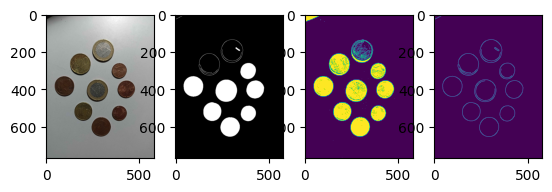

In [43]:
img = cv2.imread('./Assets/UnasCuantas.jpg')
if img.shape[1] > 800:
    factor_reduccion = img.shape[1]//500
    img = cv2.resize(img, (img.shape[1]//factor_reduccion,img.shape[0]//factor_reduccion))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

umbral = 200

th1,img_th1 = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV)
th2,img_th2 = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

img_median_blur = cv2.medianBlur(img_gris, 7)
img_gaussian_blur = cv2.GaussianBlur(img_gris, (9, 9), 3)

canny_output = cv2.Canny(img_gaussian_blur, 0, 85)

contornos2, hierarchy2 = cv2.findContours(canny_output, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)
#cv2.drawContours(img, contornos2, -1, (0,255,0), 3)

img_blur = cv2.medianBlur(img_gris, 7)

img_cont = np.zeros(img_rgb.shape, dtype=np.uint8)
#Recorre los contornos externos
for c in contornos2:
    #Área del contorno
    area = cv2.contourArea(c)
    #Área mínima (útil filtrar en ocasiones)
    if area > 10:
        #Perímetro del contorno
        perimetro = cv2.arcLength(c,True)
        #Contenedor alineado con ejes de la imagen
        x,y,w,h = cv2.boundingRect(c)
        #Mínimo contenedor ajustado para el contorno
        (cx,cy),radio = cv2.minEnclosingCircle(c)
        
        #cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)
        #print(f'Area: {area}, Perímetro: {perimetro}, Circularidad: {circularidad}, Relación perimetro circulo: {relacion_perimetro_circulo}')
            

        circularidad = 4*np.pi*area/(perimetro*perimetro)
        relacion_perimetro_circulo = perimetro/(2*np.pi*radio)

        cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)

        if  0.5 < circularidad < 1.1 and 1 < relacion_perimetro_circulo < 1.5:
            cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)
            print(f'Area: {area}, Perímetro: {perimetro}, Circularidad: {circularidad}, Relación perimetro circulo: {relacion_perimetro_circulo}')

#Hough
"""
# Convertir la imagen de contornos a escala de grises para usar con HoughCircles
img_cont_gris = cv2.cvtColor(img_cont, cv2.COLOR_RGB2GRAY)

# Aplicar un desenfoque a img_cont_gris para reducir ruido
img_cont_blur = cv2.GaussianBlur(img_cont_gris, (9, 9), 3)

img_blur = cv2.medianBlur(img_gris, 7)

circles = cv2.HoughCircles(
    img_blur, 
    cv2.HOUGH_GRADIENT, 
    dp=2, 
    minDist=30, 
    param1=70, 
    param2=80, 
    minRadius=0, 
    maxRadius=150
)

#Dibuja sobre entrada e imagen vacía
img_test = np.zeros(img_rgb.shape)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for det in circles[0]:
        x_coor, y_coor, det_radio = det
        cv2.circle(img_rgb,(int(x_coor), int(y_coor)),
            int(det_radio),(0, 255, 0), 2)
        cv2.circle(img_test,(int(x_coor), int(y_coor)),
            int(det_radio),(255, 255, 255), -1)

            if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        print(i)
        center = (i[0], i[1])
        # Dibujar el círculo externo
        cv2.circle(img, (i[0], i[1]), i[2], (0, 255, 0), 2)
    
"""

plt.subplot(1, 4, 1)
plt.imshow(img_rgb)

plt.subplot(1, 4, 2)
plt.imshow(img_cont)    

plt.subplot(1, 4, 3)
plt.imshow(img_th2)

plt.subplot(1, 4, 4)
plt.imshow(canny_output)

contornos_radi = [(c, cv2.minEnclosingCircle(c)[1]) for c in contornos2]

relacion_mm_por_pixel = 0

# Diccionario con diámetros de las monedas y su valor
monedas = {
    16.25: 0.01,  # 1 céntimo
    18.75: 0.02,  # 2 céntimos
    21.25: 0.05,  # 5 céntimos
    19.75: 0.10,  # 10 céntimos
    22.25: 0.20,  # 20 céntimos
    24.25: 0.50,  # 50 céntimos
    23.25: 1.00,  # 1 euro
    25.75: 2.00   # 2 euros
}



def countMoney():
    global relacion_mm_por_pixel
    print('La relación mm/píxel es:', relacion_mm_por_pixel)
    # Error permitido en los diámetros (en mm)
    error = 0.5
    dinero_total = 0

    conteo = {
        0.01: 0,  # 1 céntimo
        0.02: 0,  # 2 céntimos
        0.05: 0,  # 5 céntimos
        0.10: 0,  # 10 céntimos
        0.20: 0,  # 20 céntimos
        0.50: 0,  # 50 céntimos
        1.00: 0,  # 1 euro
        2.00: 0   # 2 euros
    }

    for c, radio in contornos_radi:
        diametro_modeda_pixeles = radio * 2
        print('Dinero total:', dinero_total)
        print(f'Este contorno tiene un diámetro en mm estimado: {diametro_modeda_pixeles * relacion_mm_por_pixel} mm')
        for diametro_real, valor in monedas.items():
            if (diametro_real - error) < diametro_modeda_pixeles * relacion_mm_por_pixel < (diametro_real + error):
                dinero_total += valor
                conteo[valor] += 1
                print(f'Esta moneda es de {valor} euros')
                break

    print(f'El dinero total es: {round(dinero_total, 2)} euros')
    print('Conteo de monedas:')
    for valor, cantidad in conteo.items():
        print(f'{cantidad} monedas de {valor} euros')

def on_mouse(event, x, y, flags, userdata):
    global relacion_mm_por_pixel
    if event == cv2.EVENT_LBUTTONDOWN and isCoin(x,y, img_cont):
        print(f'Mouse position: ({x}, {y})')
        # Buscar si el clic está dentro de algún contorno
        for c, radio in contornos_radi:
            dist = cv2.pointPolygonTest(c, (x, y), False)
            if dist >= 0:  # Si está dentro del contorno
                print(f'Mouse position: ({x}, {y})')
                print(f'Radio en píxeles: {radio}')
                
                diametro_modeda_pixeles = radio * 2
                # Radio real de la moneda de 1€ en mm
                diametro_moneda_real = 23.25
                
                # Relación en mm/píxel
                relacion_mm_por_pixel = diametro_moneda_real / diametro_modeda_pixeles
                
                print(f'Relación mm/píxel: {relacion_mm_por_pixel}')
                print("A contar dinero!")
                countMoney()
                break

windowName = "amor"

cv2.namedWindow(windowName)

cv2.setMouseCallback(windowName, on_mouse)

cv2.imshow(windowName,img_rgb)
while cv2.waitKey(20) != 27:
    dummy = 0    
     # Se detiene hasta pulsar tecla (>0 milisegundos)

cv2.destroyAllWindows() # Destruye todas las ventanas






def isCoin(x, y, img):
    return (0 != np.sum(img[y,x]))


